In [1]:
!pip install simclr
!pip install lightning-flash
!pip install timm
!pip install torchtyping
! Tar -xvzf imagenette2.tgz


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


x imagenette2/
x imagenette2/train/
x imagenette2/noisy_imagenette.csv
x imagenette2/val/
x imagenette2/val/n03394916/
x imagenette2/val/n03417042/
x imagenette2/val/n03445777/
x imagenette2/val/n02102040/
x imagenette2/val/n03425413/
x imagenette2/val/n03888257/
x imagenette2/val/n03028079/
x imagenette2/val/n03000684/
x imagenette2/val/n01440764/
x imagenette2/val/n02979186/
x imagenette2/val/n02979186/n02979186_7492.JPEG
x imagenette2/val/n02979186/n02979186_491.JPEG
x imagenette2/val/n02979186/n02979186_24591.JPEG
x imagenette2/val/n02979186/n02979186_26451.JPEG
x imagenette2/val/n02979186/n02979186_11372.JPEG
x imagenette2/val/n02979186/n02979186_1792.JPEG
x imagenette2/val/n02979186/n02979186_22111.JPEG
x imagenette2/val/n02979186/n02979186_18450.JPEG
x imagenette2/val/n02979186/n02979186_2002.JPEG
x imagenette2/val/n02979186/n02979186_21910.JPEG
x imagenette2/val/n02979186/n02979186_9232.JPEG
x imagenette2/val/n02979186/n02979186_10670.JPEG
x imagenette2/val/n02979186/n02979186_

x imagenette2/val/n02979186/n02979186_6531.JPEG
x imagenette2/val/n02979186/n02979186_14050.JPEG
x imagenette2/val/n02979186/n02979186_26822.JPEG
x imagenette2/val/n02979186/n02979186_1061.JPEG
x imagenette2/val/n02979186/n02979186_13280.JPEG
x imagenette2/val/n02979186/n02979186_11481.JPEG
x imagenette2/val/n02979186/n02979186_1870.JPEG
x imagenette2/val/n02979186/n02979186_3772.JPEG
x imagenette2/val/n02979186/n02979186_15401.JPEG
x imagenette2/val/n02979186/n02979186_17312.JPEG
x imagenette2/val/n02979186/n02979186_13701.JPEG
x imagenette2/val/n02979186/n02979186_11550.JPEG
x imagenette2/val/n02979186/n02979186_10341.JPEG
x imagenette2/val/n02979186/ILSVRC2012_val_00043121.JPEG
x imagenette2/val/n02979186/n02979186_20132.JPEG
x imagenette2/val/n02979186/n02979186_1630.JPEG
x imagenette2/val/n02979186/n02979186_14601.JPEG
x imagenette2/val/n02979186/n02979186_14251.JPEG
x imagenette2/val/n02979186/n02979186_18272.JPEG
x imagenette2/val/n02979186/n02979186_13740.JPEG
x imagenette2/val

In [1]:
import cv2
import os
import pathlib
import torch
import torchvision

import numpy as np
import torch.nn as nn
import torchvision.transforms as transforms

from flash.core.optimizers import LARS

from scipy.stats import ortho_group
from simclr import SimCLR
from simclr.modules.transformations import TransformsSimCLR
from simclr.modules import NT_Xent
from simclr.modules import LogisticRegression

from torchvision.utils import make_grid
from torchvision.datasets import CIFAR10
from torchtyping import TensorType, patch_typeguard
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
from torch.utils.tensorboard import SummaryWriter
from typing import Callable, Iterator, Dict
from typeguard import typechecked

from matplotlib import pyplot as plt
from torch import linalg as LA
from tqdm import tqdm as tqdm

patch_typeguard()  # use before @typechecked

In [2]:
image_size = 448
batch_size = 16
global_step = 0
epochs = 50
temperature = 0.2
projection_dim = 64
resnet = 'resnet18'
lr = 0.075 * np.sqrt(batch_size)
weight_decay = 1e-6
model_path = "logs"
epoch_num = 100
logistic_epochs = 500

In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
writer = SummaryWriter()

In [13]:
# To make it work in both Jupyter and standalone:
if "__file__" in globals():
    root = pathlib.Path(__file__).parent.resolve()
else:
    # Probably running interactively; in Jupyter, notebook path is
    # typically 'os.getcwd()', if it's not that's where we are going
    # to store the CIFAR data.
    root = pathlib.Path(os.getcwd())
    
    
train_dataset = CIFAR10(root=root, download=True, transform = TransformsSimCLR(size = image_size))
torch.manual_seed(43)
train_loader = DataLoader(train_dataset, 
                          batch_size, 
                          shuffle=False,
                          drop_last = True,
                          num_workers=2,
                          sampler = None)
test_dataset = torchvision.datasets.CIFAR10(
        root,
        train=False,
        download=True,
        transform=TransformsSimCLR(size=image_size).test_transform)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
    num_workers=2,
)

from timm.data import ImageDataset
from timm.data.transforms_factory import create_transform
from timm.data import create_dataset

tim_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor()
])

imagenette_ds_train = create_dataset(name = '', root = 'imagenette2',
                                    transform = TransformsSimCLR(size = image_size))

imagenette_ds_test = create_dataset(name = '', root = 'imagenette2', 
                                    transform = tim_transform)

tim_trainloader = torch.utils.data.DataLoader(
    imagenette_ds_train,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
    num_workers=2,
)

tim_testloader = torch.utils.data.DataLoader(
    imagenette_ds_test,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
    num_workers=2,
)

Files already downloaded and verified
Files already downloaded and verified


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000001D4B62A8940>
Traceback (most recent call last):
  File "C:\Users\Shulu\anaconda3\lib\site-packages\torch\utils\data\dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "C:\Users\Shulu\anaconda3\lib\site-packages\torch\utils\data\dataloader.py", line 1316, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


In [5]:
encoder = torch.hub.load('pytorch/vision:v0.10.0', resnet, pretrained=False) 
n_features = encoder.fc.in_features  # get dimensions of last fully-connected layer
model = SimCLR(encoder, projection_dim, n_features).to(DEVICE)

Using cache found in C:\Users\Shulu/.cache\torch\hub\pytorch_vision_v0.10.0


In [6]:
optimizer = LARS(model.parameters(), lr = lr, weight_decay = weight_decay)
criterion = NT_Xent(batch_size, temperature = temperature, world_size=1)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 
                                                       epochs, 
                                                       eta_min=0, 
                                                       last_epoch=-1)

In [7]:
@typechecked
def random_ortho_matrix_gen(dim_a: int, dim_b: int) -> Iterator[TensorType["dim_a", "dim_b"]]:
    assert dim_a >= dim_b, f"Assuming we want projection matrices (broad and short), got dims {dim_a} x {dim_b}"
    while True:
        m = ortho_group.rvs(dim=dim_a)
        for i in range(dim_a // dim_b):
            yield torch.Tensor(m[i*dim_b : (i+1)*dim_b])

@typechecked
def prior_sampler(name: str, batch_size: int, feature_dim: int) -> Callable[[], 
                                                                            TensorType["batch_size", "feature_dim"]]:
    """
    Constructs a sampling function from a named distribution. E.g., with `name=="Uniform hypersphere"`, 
    the resulting function samples `batch_size` vectors of length `feature_dim` on a uniform hypersphere.
    """
    @typechecked
    def hypersphere_sampler() -> TensorType['batch_size', 'feature_dim']:
        X = torch.normal(mean=0, std=1, size=(batch_size, feature_dim))
        return X / LA.norm(X, dim=1).unsqueeze(1)
    
    d : Dict[str,  Callable[[], TensorType["batch_size", "feature_dim"]]] = {
         "Uniform hypersphere": hypersphere_sampler, 
         "Uniform hypercube": lambda: torch.rand(size=(batch_size, feature_dim)),
         "Normal distribution": lambda: torch.normal(mean=0, std=1, size=(batch_size, feature_dim)),
        }
    if name not in d:
        raise ValueError(f"Distr '{name}' not in {d.keys()}")
    
    return d[name]

class SWD_contrastiveloss(nn.Module):
    @typechecked
    def __init__(self, batch_size: int, feature_dim: int, prior_name: str,
                 normalize_before_align: bool = True,
                 SWD_dim: int=-1, SWD_lambda: float = 1.):
        super(SWD_contrastiveloss, self).__init__()
        self.batch_size = batch_size
        self.feature_dim = feature_dim
        #self.temperature = temperature
        self.normalize_before_align = normalize_before_align
        self.sample_prior = prior_sampler(prior_name, batch_size=2*batch_size, feature_dim=feature_dim)
        self.ortho_matrix_gen = random_ortho_matrix_gen(feature_dim, SWD_dim)
        self.lmbda = SWD_lambda
        self.SWD_dim = SWD_dim
        
    @typechecked
    def forward(self, zi: TensorType["batch_size", "feature_dim"],
                zj: TensorType["batch_size", "feature_dim"]):
        # Following "Algorithm 1" in the paper
        n : int = self.batch_size
        d = zi.size(dim = -1)
        
        # Project zi/zj onto hypersphere (i.e. normalize).
        if self.normalize_before_align:
            zi = zi / LA.norm(zi, dim=1).unsqueeze(1)
            zj = zj / LA.norm(zj, dim=1).unsqueeze(1)
        loss_align = ((zi - zj)**2).sum() / (n*d)
        Z : TensorType[2*self.batch_size, self.feature_dim] = torch.cat((zi, zj), dim=0).to(DEVICE)
        P : TensorType[2*self.batch_size, self.feature_dim] = self.sample_prior().to(DEVICE)
        W : TensorType[self.feature_dim, self.SWD_dim] = next(self.ortho_matrix_gen).to(DEVICE)
        
        
        H_perp, P_perp = Z @ W, P @ W 
        #loss_distr = torch.Tensor(0.) #Getting compiler error if we do like that, solution done below.
        loss_distr = 0 #commented out torch.Tensor since we are supposed to get a singular value anyway.
        for j in range(self.SWD_dim):
            hj, pj = H_perp[:, j], P_perp[:, j]
            hj, _ = torch.sort(hj)
            pj, _ = torch.sort(pj)
            loss_distr = loss_distr + ((hj - pj)**2).sum()
        loss_distr = loss_distr / (self.feature_dim * self.SWD_dim)
        return loss_align + self.lmbda * loss_distr
    
swd_normal_crit = SWD_contrastiveloss(batch_size, normalize_before_align=False, feature_dim=64, SWD_lambda=5, SWD_dim=64, prior_name = "Normal distribution")
swd_cube_crit = SWD_contrastiveloss(batch_size, normalize_before_align=False, feature_dim=64, SWD_lambda=5, SWD_dim=64, prior_name = "Uniform hypercube")
swd_sphere_crit = SWD_contrastiveloss(batch_size, feature_dim=64, SWD_lambda=5, SWD_dim=64, prior_name = "Uniform hypersphere")


In [8]:
def train(global_step, loader, model, criterion, optimizer, writer):
    loss_epoch = 0
    for steps, ((x_i, x_j), _) in enumerate(loader):
        x_i = x_i.to(DEVICE)
        x_j = x_j.to(DEVICE)
        
        optimizer.zero_grad()
        h_i, h_j, z_i, z_j = model(x_i, x_j)

        loss = criterion(z_i, z_j)
        loss.backward()
        optimizer.step()

        if steps % 50 == 0:
            print(f"Step [{steps}/{len(loader)}]\t Loss: {loss.item()}")

        writer.add_scalar("Loss/train_epoch", loss.item(), global_step)
        loss_epoch += loss.item()
        global_step += 1
    return loss_epoch

In [9]:
for epoch in tqdm(range(epochs)):
    loss_epoch = train(global_step, tim_trainloader, model, criterion, optimizer, writer)
    scheduler.step()
    writer.add_scalar("Loss/train", loss_epoch / len(train_loader), epoch)
    print(
        f"Epoch [{epoch}/{epochs}]\t Loss: {loss_epoch / len(train_loader)}\t"
    )

  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Step [0/245]	 Loss: 3.4264578819274902
Step [50/245]	 Loss: 3.1027915477752686
Step [100/245]	 Loss: 3.328374147415161
Step [150/245]	 Loss: 3.0530965328216553
Step [200/245]	 Loss: 3.3758718967437744


  2%|█▌                                                                              | 1/50 [02:21<1:55:27, 141.38s/it]

Epoch [0/50]	 Loss: 0.25385414955139163	
Step [0/245]	 Loss: 3.5913913249969482
Step [50/245]	 Loss: 3.1535210609436035
Step [100/245]	 Loss: 2.770357370376587
Step [150/245]	 Loss: 3.3171942234039307
Step [200/245]	 Loss: 2.9733917713165283


  4%|███▏                                                                            | 2/50 [04:42<1:53:08, 141.42s/it]

Epoch [1/50]	 Loss: 0.23917203559875488	
Step [0/245]	 Loss: 3.3199827671051025
Step [50/245]	 Loss: 2.729409694671631
Step [100/245]	 Loss: 2.945854663848877
Step [150/245]	 Loss: 3.092888593673706
Step [200/245]	 Loss: 3.155611991882324


  6%|████▊                                                                           | 3/50 [07:03<1:50:31, 141.10s/it]

Epoch [2/50]	 Loss: 0.2353500350189209	
Step [0/245]	 Loss: 2.901808023452759
Step [50/245]	 Loss: 2.91709303855896
Step [100/245]	 Loss: 3.388714075088501
Step [150/245]	 Loss: 3.4245245456695557
Step [200/245]	 Loss: 3.632906198501587


  8%|██████▍                                                                         | 4/50 [09:25<1:48:27, 141.46s/it]

Epoch [3/50]	 Loss: 0.23145656867980957	
Step [0/245]	 Loss: 3.3532633781433105
Step [50/245]	 Loss: 2.754762649536133
Step [100/245]	 Loss: 2.5779407024383545
Step [150/245]	 Loss: 2.887131929397583
Step [200/245]	 Loss: 3.012369394302368


 10%|████████                                                                        | 5/50 [11:46<1:45:49, 141.11s/it]

Epoch [4/50]	 Loss: 0.2266534839630127	
Step [0/245]	 Loss: 2.880537509918213
Step [50/245]	 Loss: 2.8636815547943115
Step [100/245]	 Loss: 3.242394208908081
Step [150/245]	 Loss: 2.6133880615234375
Step [200/245]	 Loss: 2.6480324268341064


 12%|█████████▌                                                                      | 6/50 [14:08<1:43:49, 141.58s/it]

Epoch [5/50]	 Loss: 0.22101169319152833	
Step [0/245]	 Loss: 3.833009719848633
Step [50/245]	 Loss: 3.079007148742676
Step [100/245]	 Loss: 2.9926507472991943
Step [150/245]	 Loss: 2.6734495162963867
Step [200/245]	 Loss: 2.574357748031616


 14%|███████████▏                                                                    | 7/50 [16:31<1:41:45, 141.98s/it]

Epoch [6/50]	 Loss: 0.21788467288970947	
Step [0/245]	 Loss: 2.952504873275757
Step [50/245]	 Loss: 3.258237361907959
Step [100/245]	 Loss: 2.632211685180664
Step [150/245]	 Loss: 2.4355056285858154
Step [200/245]	 Loss: 2.3005471229553223


 16%|████████████▊                                                                   | 8/50 [18:53<1:39:19, 141.90s/it]

Epoch [7/50]	 Loss: 0.21310966587066651	
Step [0/245]	 Loss: 3.3017163276672363
Step [50/245]	 Loss: 2.871973752975464
Step [100/245]	 Loss: 2.9993653297424316
Step [150/245]	 Loss: 3.017265796661377
Step [200/245]	 Loss: 2.843146562576294


 18%|██████████████▍                                                                 | 9/50 [21:07<1:35:25, 139.65s/it]

Epoch [8/50]	 Loss: 0.21360934173583984	
Step [0/245]	 Loss: 2.816084384918213
Step [50/245]	 Loss: 2.788727283477783
Step [100/245]	 Loss: 2.925933361053467
Step [150/245]	 Loss: 2.139244318008423
Step [200/245]	 Loss: 2.630711555480957


 20%|███████████████▊                                                               | 10/50 [23:24<1:32:35, 138.88s/it]

Epoch [9/50]	 Loss: 0.20989925895690917	
Step [0/245]	 Loss: 2.8696846961975098
Step [50/245]	 Loss: 2.2522623538970947
Step [100/245]	 Loss: 2.5159008502960205
Step [150/245]	 Loss: 2.3228347301483154
Step [200/245]	 Loss: 2.881690263748169


 22%|█████████████████▍                                                             | 11/50 [25:46<1:30:51, 139.77s/it]

Epoch [10/50]	 Loss: 0.20591063556671144	
Step [0/245]	 Loss: 2.4479503631591797
Step [50/245]	 Loss: 2.4677023887634277
Step [100/245]	 Loss: 1.6611558198928833
Step [150/245]	 Loss: 2.397282600402832
Step [200/245]	 Loss: 2.816981554031372


 24%|██████████████████▉                                                            | 12/50 [28:06<1:28:30, 139.75s/it]

Epoch [11/50]	 Loss: 0.20540248886108398	
Step [0/245]	 Loss: 2.3967785835266113
Step [50/245]	 Loss: 2.5458290576934814
Step [100/245]	 Loss: 2.9974212646484375
Step [150/245]	 Loss: 2.947328567504883
Step [200/245]	 Loss: 2.7166357040405273


 26%|████████████████████▌                                                          | 13/50 [30:27<1:26:25, 140.14s/it]

Epoch [12/50]	 Loss: 0.20205640090942384	
Step [0/245]	 Loss: 2.793996810913086
Step [50/245]	 Loss: 2.583216667175293
Step [100/245]	 Loss: 2.221113920211792
Step [150/245]	 Loss: 2.5961146354675293
Step [200/245]	 Loss: 2.523089647293091


 28%|██████████████████████                                                         | 14/50 [32:42<1:23:09, 138.59s/it]

Epoch [13/50]	 Loss: 0.2008092097091675	


 28%|██████████████████████                                                         | 14/50 [32:45<1:24:12, 140.36s/it]


KeyboardInterrupt: 

In [20]:
def inference(loader, simclr_model, device):
    feature_vector = []
    labels_vector = []

    if loader == tim_trainloader:

        for step, ((x, _), y) in enumerate(loader):
        
            x = x.to(DEVICE)

            # get encoding
            with torch.no_grad():
                h, _, z, _ = simclr_model(x, x) #h = output after the average-pooling layer.

            h = h.detach()

            feature_vector.extend(h.cpu().detach().numpy())
            labels_vector.extend(y.numpy())

            if step % 20 == 0:
                print(f"Step [{step}/{len(loader)}]\t Computing features...")
    else:
        for step, (x, y) in enumerate(loader):
        
            x = x.to(DEVICE)

            # get encoding
            with torch.no_grad():
                h, _, z, _ = simclr_model(x, x)

            h = h.detach()

            feature_vector.extend(h.cpu().detach().numpy())
            labels_vector.extend(y.numpy())

            if step % 20 == 0:
                print(f"Step [{step}/{len(loader)}]\t Computing features...")

    feature_vector = np.array(feature_vector)
    labels_vector = np.array(labels_vector)
    print("Features shape {}".format(feature_vector.shape))
    return feature_vector, labels_vector

def get_features(context_model, train_loader, test_loader, device):
    train_X, train_y = inference(train_loader, context_model, device)
    test_X, test_y = inference(test_loader, context_model, device)
    return train_X, train_y, test_X, test_y


def create_data_loaders_from_arrays(X_train, y_train, X_test, y_test, batch_size):
    train = torch.utils.data.TensorDataset(
        torch.from_numpy(X_train), torch.from_numpy(y_train)
    )
    train_loader = torch.utils.data.DataLoader(
        train, batch_size=batch_size, shuffle=False
    )

    test = torch.utils.data.TensorDataset(
        torch.from_numpy(X_test), torch.from_numpy(y_test)
    )
    test_loader = torch.utils.data.DataLoader(
        test, batch_size=batch_size, shuffle=False
    )
    return train_loader, test_loader

In [21]:
def k_means_on_img(image, k, max_iter=100, epsilon=0.2, attempts=10, normalize=False, plot=False):
    flag = cv2.KMEANS_RANDOM_CENTERS
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, max_iter, epsilon)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    if plot:
        # show the image
        plt.imshow(image)
        plt.show()

    if normalize:
        # normalize img to 0-255
        norm_image = cv2.normalize(image, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
        image = norm_image.astype(np.uint8)

    # reshape the image to a 2D array of pixels and 3 color values (RGB)
    pixel_values = image.reshape((-1, 3))
    # convert to float
    pixel_values = np.float32(pixel_values)
    
    # some documentation -> https://docs.opencv.org/4.x/d1/d5c/tutorial_py_kmeans_opencv.html
    _, labels, (centers) = cv2.kmeans(pixel_values, k, None, criteria, attempts, flag)
    
    # convert back to 8 bit values
    centers = np.uint8(centers)

    # flatten the labels array
    labels = labels.flatten()
    
    # convert all pixels to the color of the centroids
    segmented_image = centers[labels.flatten()]
    
    # reshape back to the original image dimension
    segmented_image = segmented_image.reshape(image.shape)
    
    if plot:
        # show the image
        plt.imshow(segmented_image)
        plt.show()
    return segmented_image

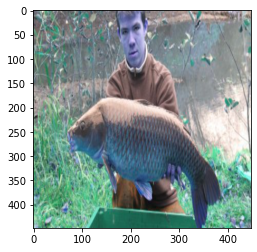

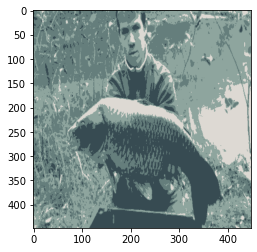

In [22]:
for images, _ in tim_testloader:
    batch = images.cpu().detach().numpy()
    img_idx = 15
    image = batch[img_idx]
    # put color channels as last dimension 
    image = np.moveaxis(image, 0, -1)

    k = 8
    segmented_image = k_means_on_img(image, 4, max_iter=100, epsilon=0.2, 
                                     attempts=10, normalize=True, 
                                     plot=True)
    break

In [25]:
print("### Creating features from pre-trained context model ###")

train_X, train_y, test_X, test_y = get_features(
    model, tim_trainloader, tim_testloader, DEVICE
)

arr_train_loader, arr_test_loader = create_data_loaders_from_arrays(
    train_X, train_y, test_X, test_y, batch_size
)

### Creating features from pre-trained context model ###
Step [0/245]	 Computing features...
Step [20/245]	 Computing features...
Step [40/245]	 Computing features...
Step [60/245]	 Computing features...
Step [80/245]	 Computing features...
Step [100/245]	 Computing features...
Step [120/245]	 Computing features...
Step [140/245]	 Computing features...
Step [160/245]	 Computing features...
Step [180/245]	 Computing features...
Step [200/245]	 Computing features...
Step [220/245]	 Computing features...
Step [240/245]	 Computing features...
Features shape (3920, 512)
hi
Step [0/245]	 Computing features...
Step [20/245]	 Computing features...
Step [40/245]	 Computing features...
Step [60/245]	 Computing features...
Step [80/245]	 Computing features...
Step [100/245]	 Computing features...
Step [120/245]	 Computing features...
Step [140/245]	 Computing features...
Step [160/245]	 Computing features...
Step [180/245]	 Computing features...
Step [200/245]	 Computing features...
Step [220/245